In [3]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *

In [4]:
handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
f = 1
mu = 0
apply_fine_CFO = 0

waveform = handle.read_samples()
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)

detected NID2 is 2
max correlation is 706292.0482243871 at 824


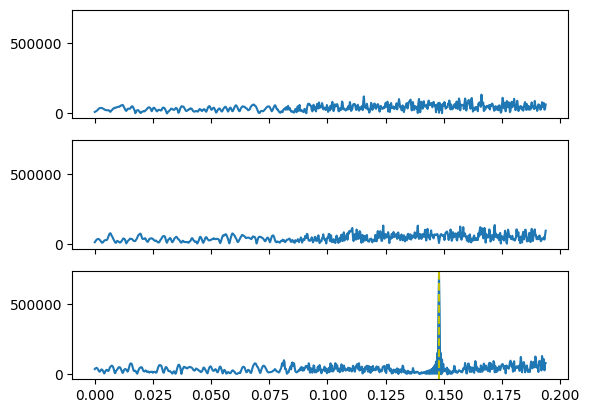

In [5]:
# optimized correlation with decimation, performed with integers

dec_factor = 8
FFT_LEN=256
waveform2 = scipy.signal.decimate(waveform, dec_factor, ftype='fir')
waveform2 /= max(waveform2.real.max(), waveform2.imag.max())
waveform2 *= 2**7
waveform2 = waveform2.real.astype(int) + 1j*waveform2.imag.astype(int)

peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    PSS = np.zeros(FFT_LEN, 'complex')
    PSS[64:64+127] = nrPSS(current_NID2)
    refWaveform = np.fft.ifft(np.fft.fftshift(PSS))
    refWaveform /= max(refWaveform.real.max(), refWaveform.imag.max())
    refWaveform *= 2**7
    refWaveform = refWaveform.real.astype(int) + 1j*refWaveform.imag.astype(int)
    temp = scipy.signal.correlate(waveform2[:1000], refWaveform, 'valid')  # correlate over 1000 samples
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/(fs/dec_factor)*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)

axs[detected_NID2].axvline(x = t_corr[peak_index[detected_NID2]], color = 'y', linestyle = '--', label = 'axvline - full height')
print(f'detected NID2 is {detected_NID2}')
print(f'max correlation is {peak_value[detected_NID2]} at {peak_index[detected_NID2] + FFT_LEN}')
# np.abs(np.dot(refWaveform.conj(), waveform2[peak_index[detected_NID2] :][:128]))

start_pos for SSB1 is 842
start_pos for SSB2 is 77642


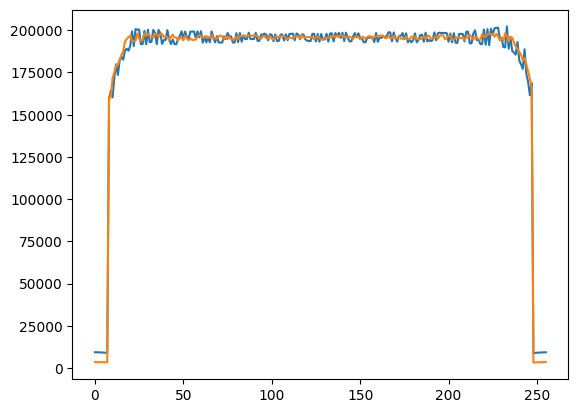

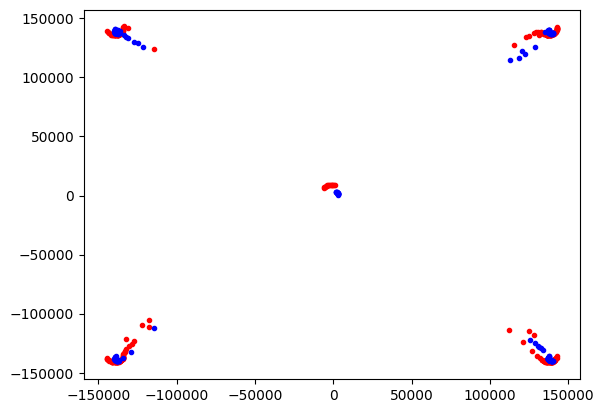

In [13]:
FFT_LEN = 256
cp1 = 18
waveform2 = scipy.signal.decimate(waveform, dec_factor, ftype='fir')
waveform2 /= max(waveform2.real.max(), waveform2.imag.max())
waveform2 *= ((2**15) - 1)
waveform2 = waveform2.real.astype(int) + 1j*waveform2.imag.astype(int)
start_pos = 842
print(f'start_pos for SSB1 is {start_pos}')
SSB1 = waveform2[start_pos:][:FFT_LEN]
SSB1_fd = np.fft.fftshift(np.fft.fft(SSB1))

delta_t = 0.02
start_pos = start_pos + int(0.02 * fs / dec_factor)
print(f'start_pos for SSB2 is {start_pos}')
SSB2 = waveform2[start_pos:][:FFT_LEN]
SSB2_fd = np.fft.fftshift(np.fft.fft(SSB2))

plt.plot(np.abs(SSB1_fd))
plt.plot(np.abs(SSB2_fd))
plt.show()

plt.plot(SSB1_fd.real, SSB1_fd.imag, 'r.')
plt.plot(SSB2_fd.real, SSB2_fd.imag, 'b.')